In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#from sklearn.cluster import KMeans

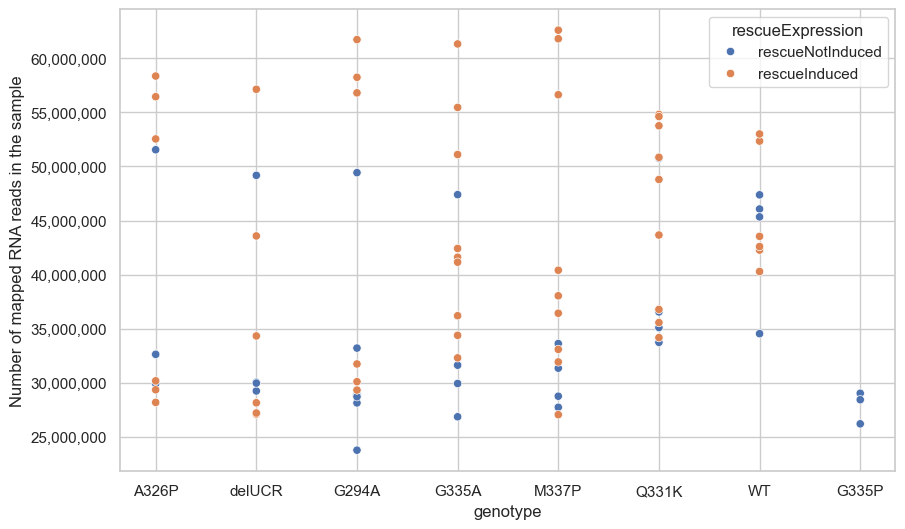

In [ ]:
'''
Initial general correlation heatmap of genotype and library depth/size. 
'''

input_data = pd.read_csv('filtered_data.csv')
aligned_size = pd.read_csv('input_data/aligned_library_size.csv')
metadata = pd.read_csv('input_data/metadata_halleger_hek.csv')

# reformat/cleanup aligned_size entries
aligned_size['sample_name'] = aligned_size['sample_id'].str.replace(".sorted", "", regex=False) 
merged = pd.merge(aligned_size, metadata, how='left', on='sample_name').drop_duplicates()

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged, x="genotype", y="library_size", hue="rescueExpression")
plt.ylabel("Number of mapped RNA reads in the sample")
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

C:\Users\alexa\AppData\Local\Temp\ipykernel_87948\3161567433.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['genotype_label'] = filtered_data.apply(


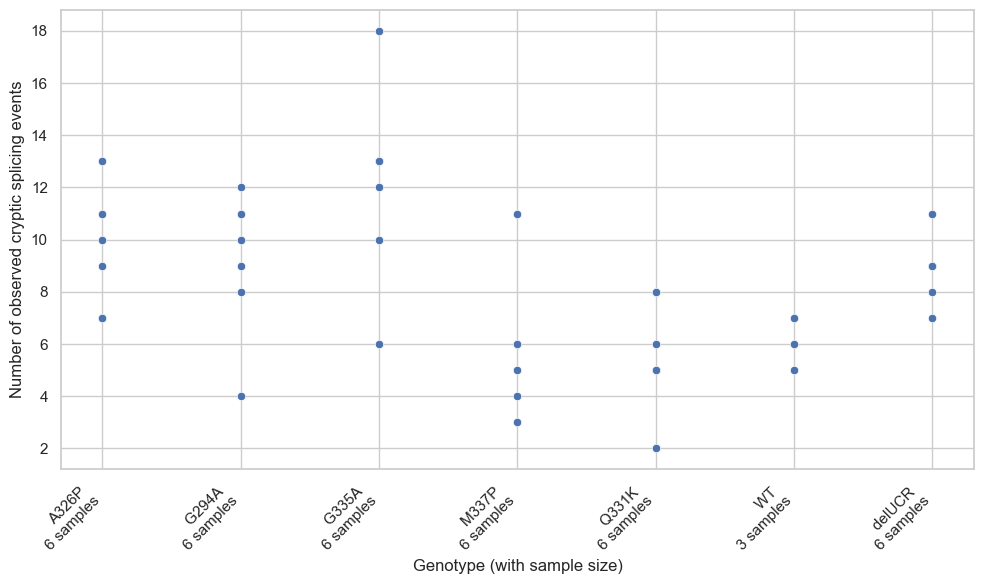

In [25]:
'''
HEATMAP ANALYSIS, 

Finding number of unique cryptic events per sample now (cluster refers to the group).

Investigating how many unique cryptic events show up in each sample (which has 'rescueInduced' & 'TDP34kd')
'''

# read in filtered data
input_data = pd.read_csv('filtered_data.csv')

# Flag cryptic splicing events
input_data['cryptic_event_detected'] = input_data['junction_count'] >= 2

# Count distinct cryptic samples per genotype
genotype_sample_sizes = input_data.groupby('genotype')['sample_name'].nunique().reset_index()
genotype_sample_sizes.columns = ['genotype', 'genotype_sample_size']
input_data = input_data.merge(genotype_sample_sizes, on='genotype', how='left')

# Filter for these detected distinct cryptic events
filtered_data = input_data[input_data['cryptic_event_detected']]

# Add sample size to labels
filtered_data['genotype_label'] = filtered_data.apply(
    lambda row: f"{row['genotype']} \n{row['genotype_sample_size']} samples", axis=1
)

# Count distinct cryptic junctions per sample
summary = (
    filtered_data.groupby('sample_name')
    .agg(
        n_observed_cryptics=('junction_coords', 'nunique'),
        genotype_sample_size=('genotype_sample_size', 'first'),
        genotype_label=('genotype_label', 'first')
    )
    .reset_index()
)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=summary, x='genotype_label', y='n_observed_cryptics')
plt.ylabel("Number of observed cryptic splicing events")
plt.xlabel("Genotype (with sample size)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


C:\Users\alexa\AppData\Local\Temp\ipykernel_87948\1293311361.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['genotype_label'] = filtered_data.apply(


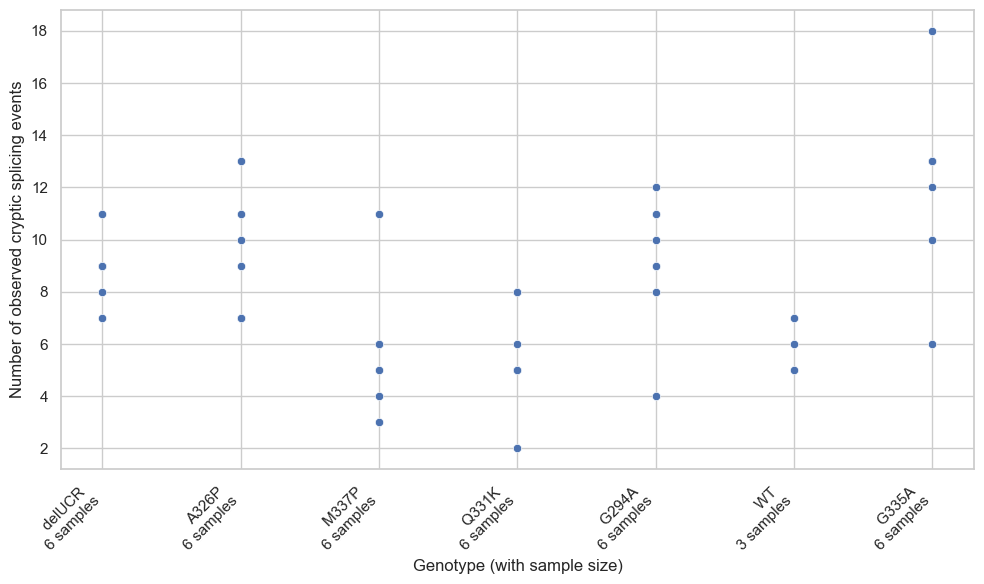

In [26]:
"""
Heatmap (Ordered):

Finding correlation between number of observed cryptics and condensation propensity.

This is done by reordering the genotypes using an arbitrary condensation score. 
"""

# Create arbitrary condensation scores
genotype_cond = pd.DataFrame({
    'genotype': ["G335A", "WT", "G294A", "Q331K", "M337P", "A326P", "delUCR"],
    'score': [7, 6, 5, 4, 3, 2, 1]
})

# Same code as previous cell
input_data = pd.read_csv('filtered_data.csv')
input_data['cryptic_event_detected'] = input_data['junction_count'] >= 2

genotype_sample_sizes = input_data.groupby('genotype')['sample_name'].nunique().reset_index()
genotype_sample_sizes.columns = ['genotype', 'genotype_sample_size']
input_data = input_data.merge(genotype_sample_sizes, on='genotype', how='left')

filtered_data = input_data[input_data['cryptic_event_detected']]
filtered_data['genotype_label'] = filtered_data.apply(
    lambda row: f"{row['genotype']} \n{row['genotype_sample_size']} samples", axis=1
)

# Add condensation score column 
filtered_data = filtered_data.merge(genotype_cond, on='genotype', how='left')
summary = (
    filtered_data.groupby('sample_name')
    .agg(
        n_observed_cryptics=('junction_coords', 'nunique'),
        genotype_label=('genotype_label', 'first'),
        score=('score', 'first')
    )
    .reset_index()
)

# Reorder based on condensation scores
summary['genotype_label'] = pd.Categorical(
    summary['genotype_label'],
    categories=summary.sort_values('score')['genotype_label'].unique(),
    ordered=True
)


# Plot 
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=summary, x='genotype_label', y='n_observed_cryptics')
plt.ylabel("Number of observed cryptic splicing events")
plt.xlabel("Genotype (with sample size)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


There seems to be no clear correlation with condensation propensity using the arbitrary scores

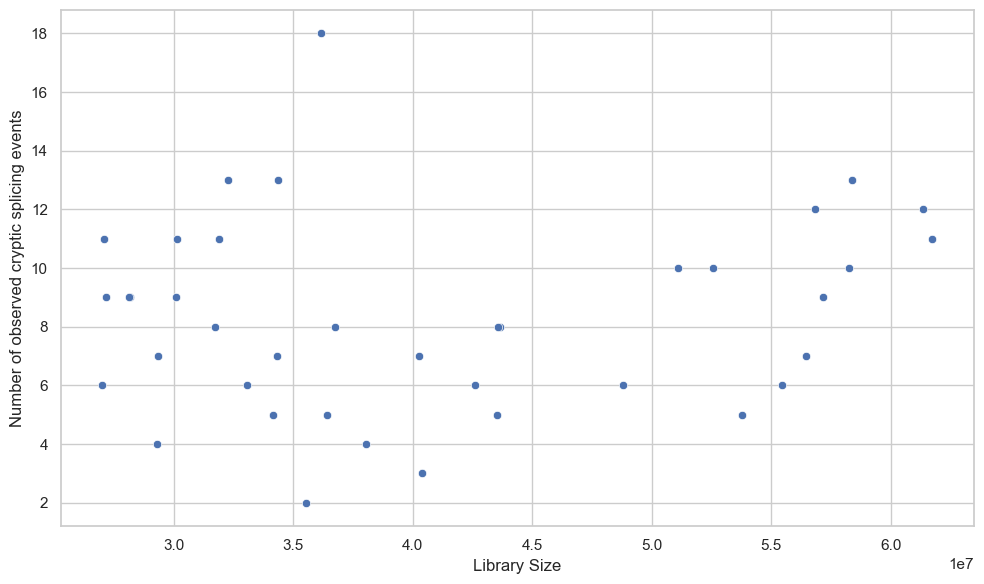

In [28]:
'''
Heatmap of library depth vs number of observed cryptics.

Discards the genotypes for now
'''

aligned_size = pd.read_csv('input_data/aligned_library_size.csv')

# Repeated code from earlier cells
input_data = pd.read_csv('filtered_data.csv')
input_data['cryptic_event_detected'] = input_data['junction_count'] >= 2
genotype_sample_sizes = input_data.groupby('genotype')['sample_name'].nunique().reset_index()
genotype_sample_sizes.columns = ['genotype', 'genotype_sample_size']
input_data = input_data.merge(genotype_sample_sizes, on='genotype', how='left')
filtered = input_data[input_data['cryptic_event_detected']].copy()
filtered['genotype_label'] = filtered.apply(
    lambda row: f"{row['genotype']} \n{row['genotype_sample_size']} samples", axis=1
)

summary = (
    filtered_data.groupby('sample_name')
    .agg(
        n_observed_cryptics=('junction_coords', 'nunique'),
        genotype_sample_size=('genotype_sample_size', 'first'),
        genotype_label=('genotype_label', 'first')
    )
    .reset_index()
)

# Add aligned size 
aligned_size['sample_name'] = aligned_size['sample_id'].str.replace(".sorted", "", regex=False)
summary = summary.merge(aligned_size[['sample_name', 'library_size']], on='sample_name', how='left')

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=summary, x='library_size', y='n_observed_cryptics')
plt.xlabel("Library Size")
plt.ylabel("Number of observed cryptic splicing events")
plt.tight_layout()
plt.show()

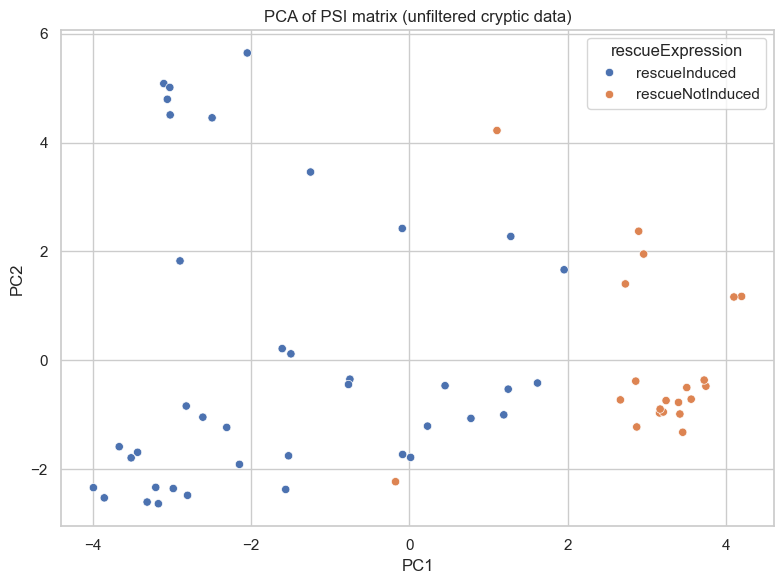

In [41]:
'''
PCA

To reduce dimensionality among the highly correlated vairables: junction count and psi.
''' 

input_data = pd.read_csv('unfiltered_cryptic_data.csv')
metadata = pd.read_csv('input_data/metadata_halleger_hek.csv')

# Clean up psi entries, drop duplicates and unnecessary columns
input_data['psi'] = input_data['psi'].fillna(0)
df = input_data[['psi', 'junction_coords', 'sample_name']].drop_duplicates()

# Pivot (make samples the columns)
wide_df = df.pivot_table(
    index='junction_coords', 
    columns='sample_name', 
    values='psi', 
    fill_value=0
)

#df_standardized = wide_df.sub(wide_df.mean(axis=1), axis=0)
#df_standardized = df_standardized.div(wide_df.std(axis=1), axis=0)

# Normalise
scaler = StandardScaler()
scaled_df = pd.DataFrame(
    scaler.fit_transform(wide_df),
    index=wide_df.index,
    columns=wide_df.columns
)

pca = PCA()
pca_result = pca.fit_transform(scaled_df.T)

# Save results
pca_df = pd.DataFrame(pca_result[:, :2],  # Only PC1 and PC2
                      columns=['PC1', 'PC2'],
                      index=scaled_df.columns).reset_index()
pca_df = pca_df.rename(columns={'index': 'sample_name'})
pca_merged = pca_df.merge(metadata, on='sample_name', how='left')

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_merged, x='PC1', y='PC2', hue='rescueExpression')
plt.title("PCA of PSI matrix (unfiltered cryptic data)")
plt.tight_layout()
plt.show()

The two groups rescueInduced and rescueNotInduced are well separated along PC1, i.e. PC1 captures a lot of variation related to rescue expression. 

This justifies classification modelling. 

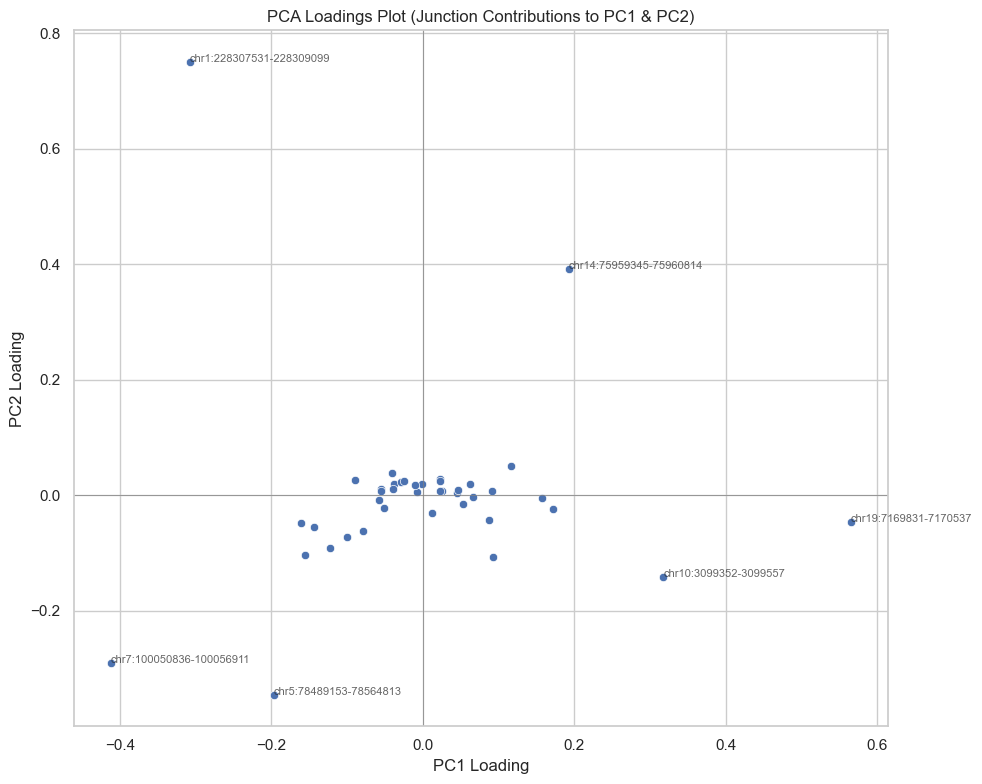

In [42]:
'''
PCA Loadings
'''

# Loadings matrix
loadings = pca.components_.T

loadings_df = pd.DataFrame(loadings[:, :2],  # Only PC1 and PC2
                           index=wide_df.index,
                           columns=['PC1_loading', 'PC2_loading'])

# Top contributing junctions
top_n = 5
top_pc1 = loadings_df['PC1_loading'].abs().sort_values(ascending=False).head(top_n).index
top_pc2 = loadings_df['PC2_loading'].abs().sort_values(ascending=False).head(top_n).index
top_junctions = top_pc1.union(top_pc2)

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1_loading', y='PC2_loading', data=loadings_df)

for junction in top_junctions:
    x = loadings_df.loc[junction, 'PC1_loading']
    y = loadings_df.loc[junction, 'PC2_loading']
    plt.text(x, y, junction, fontsize=8, alpha=0.7)

plt.title("PCA Loadings Plot (Junction Contributions to PC1 & PC2)")
plt.xlabel("PC1 Loading")
plt.ylabel("PC2 Loading")
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)
plt.grid(True)
plt.tight_layout()
plt.show()


chr1:228307531-228309099 (strong on PC2), chr19:7169831-7170537 (strong on PC1), chr14:75959345-75960814

these outliers have greater contributions to the principal components, and are potentially influential junctions

[0.21664705 0.1494075  0.10836031 0.09063873 0.0815379 ]


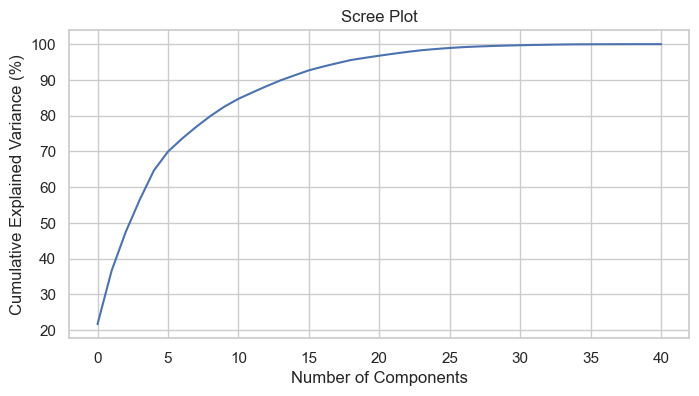

In [43]:
print(pca.explained_variance_ratio_[:5])

plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Scree Plot')
plt.grid(True)
plt.show()